In [1]:
import h5py
import matplotlib.pyplot as plt
import numpy as np

In [2]:
data_loc = "D:/Beam Characterization/2019_3_7/"
fname = "2019_3_7.h5"

In [3]:
with h5py.File(data_loc+fname, 'r') as f:
    for name in f.keys():
        print(name)

1551987078 22mJ 2Hz ablation new spot scan 1
1551987444 test
1551988084 find spot 1
1551988543 scan 1
1551989074 new spot 2
1551989245 scan 2
1551990536 new spot 3
1551990737 scan 3
1551999596 new spot 4
1552000033 22mJ ablation decay 1
1552000889 new spot 5
1552000956 22mJ ablation decay 2
1552001353 new spot 6
1552001469 22mJ ablation decay 3
1552002585 new spot 7
1552002750 16mJ ablation decay 1
1552003101 27mJ ablation decay 1 same spot as previous
1552003640 new spot 8 
1552003688 27mJ ablation decay 2
1552004704 27mJ ablation decay 2 continue after crash
1552005308 new spot 9
1552005373 27mJ ablation decay run 3
1552006199 new spot 10
1552006761 35mJ ablation decay 1
1552008747 new spot 11
1552008803 35mJ ablation decay 2
1552009737 new spot 12
1552009798 35mJ ablation decay 3


In [33]:
run_name = "/1552000033 22mJ ablation decay 1"
fast_daq = {}
with h5py.File(data_loc+fname, 'r') as f:
    grp = f[run_name]
    readout = grp['readout']
    wavemeter = readout['WA1500'].value
    fast_start = grp.attrs['time_offset']
    for dset in readout['PXIe-5171'].items():
        fast_daq[dset[0]] = dset[1].value

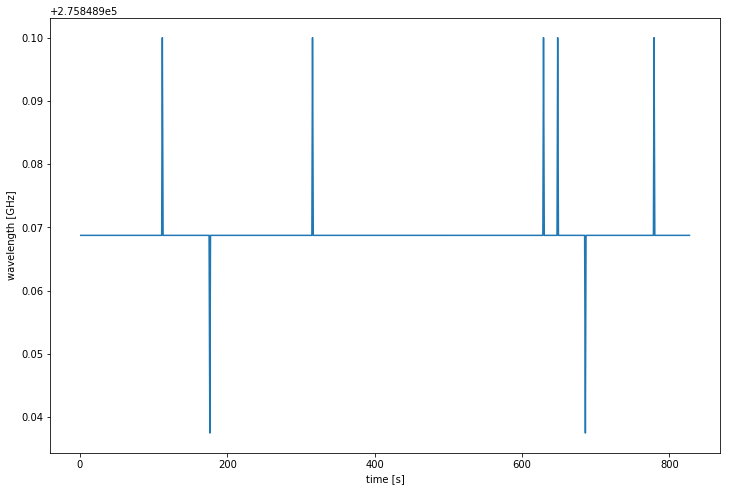

In [34]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(wavemeter[:,0],wavemeter[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('wavelength [GHz]');

In [45]:
wavemeter[:,1]

array([275848.97, 275848.97, 275848.97, ..., 275848.97, 275848.97,
       275848.97], dtype=float32)

205


Text(0.5, 0, 'time [ms]')

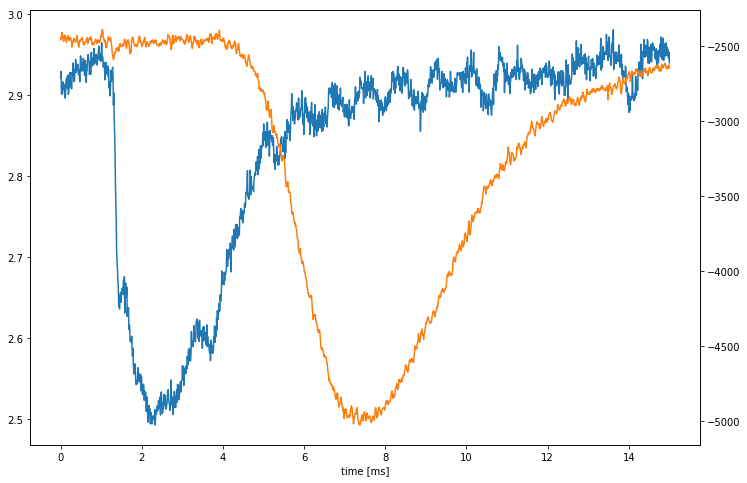

In [35]:
def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]

rate = 1/2
wavelength_values = []
for idx in yag_fire:
    wavelength_values.append((int(idx), wavemeter[:,1][find_nearest_idx(wavemeter[:,0], idx*rate)]))
wavelength_values = np.array(wavelength_values)

idx = 100
idx = yag_fire[idx]
print(idx)

x = np.linspace(0,1500,1500)/100

data_a = fast_daq['PXIe5171_{0}'.format(idx)][:,1]/fast_daq['PXIe5171_{0}'.format(idx)][:,4]
data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]

fig, ax = plt.subplots(figsize = (12,8))
ax.plot(x, data_a)
ax1 = ax.twinx()
ax1.plot(x, data_f, 'C1')

ax.set_xlabel("time [ms]")

In [36]:
import tqdm
integrals = []
x = np.linspace(0,1500,1500)/100
dx = 1/1e5

for idx in tqdm.tqdm(yag_fire):
    # Check if UV is on
    if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
        data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
        background = np.trapz(data_f[:100], dx=dx)
        signal = np.trapz(data_f[200:1500], dx=dx)-13*background
        integrals.append((idx,signal*-1,background*-1))
integrals = np.array(integrals)

100%|███████████████████████████████████████████████████████████████████████████| 1539/1539 [00:00<00:00, 20249.37it/s]


Text(0, 0.5, 'integrated fluorescence [ADC units]')

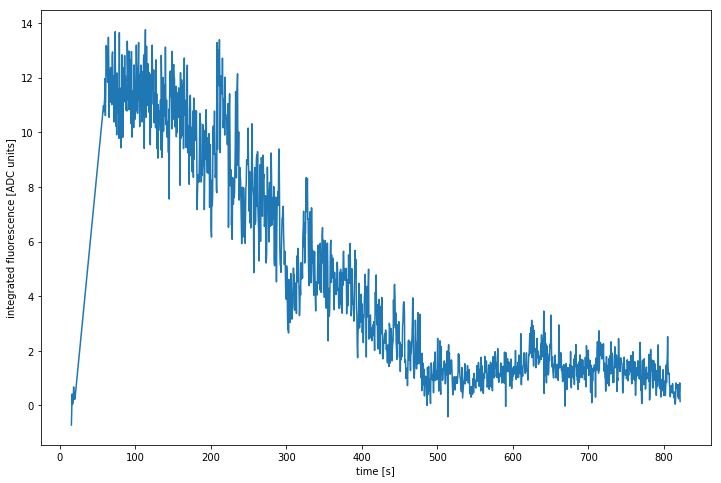

In [37]:
fig, ax = plt.subplots(figsize = (12,8))
ax.plot(integrals[:,0]*1/2,integrals[:,1])
ax.set_xlabel('time [s]')
ax.set_ylabel('integrated fluorescence [ADC units]')

In [39]:
integrals_runs = {}
run_names = ["1552000033 22mJ ablation decay 1", "1552000956 22mJ ablation decay 2",
             "1552001469 22mJ ablation decay 3", "1552002750 16mJ ablation decay 1",
             "1552003101 27mJ ablation decay 1 same spot as previous",
             "1552003688 27mJ ablation decay 2", "1552004704 27mJ ablation decay 2 continue after crash",
             "1552005373 27mJ ablation decay run 3", "1552006761 35mJ ablation decay 1",
             "1552008803 35mJ ablation decay 2", "1552009798 35mJ ablation decay 3"]
for run_name in tqdm.tqdm(run_names):
    fast_daq = {}
    with h5py.File(data_loc+fname, 'r') as f:
        grp = f[run_name]
        readout = grp['readout']
        wavemeter = readout['WA1500'].value
        fast_start = grp.attrs['time_offset']
        for dset in readout['PXIe-5171'].items():
            fast_daq[dset[0]] = dset[1].value
    yag_fire = [idx for idx in range(1,len(fast_daq)) if fast_daq['PXIe5171_{0}'.format(idx)][:,5].max() > 300]
    if run_name == "1552000033 22mJ ablation decay 1":
        yag_fire = np.array(yag_fire)[np.array(yag_fire) > 50]
    
    x = np.linspace(0,1500,1500)/100
    dx = 1/1e5

    integrals = []
    for idx in yag_fire:
        # Check if UV is on
        if fast_daq['PXIe5171_{0}'.format(idx)][:,4].min() > 1e3:
            data_f = fast_daq['PXIe5171_{0}'.format(idx)][:,2]
            background = np.trapz(data_f[:100], dx=dx)
            signal = np.trapz(data_f[200:1500], dx=dx)-13*background
            integrals.append((idx,signal*-1,background*-1))
    integrals = np.array(integrals)
    integrals_runs[run_name] = integrals

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:07<00:00,  1.02s/it]


invalid literal for int() with base 10: 'previous'
invalid literal for int() with base 10: 'crash'


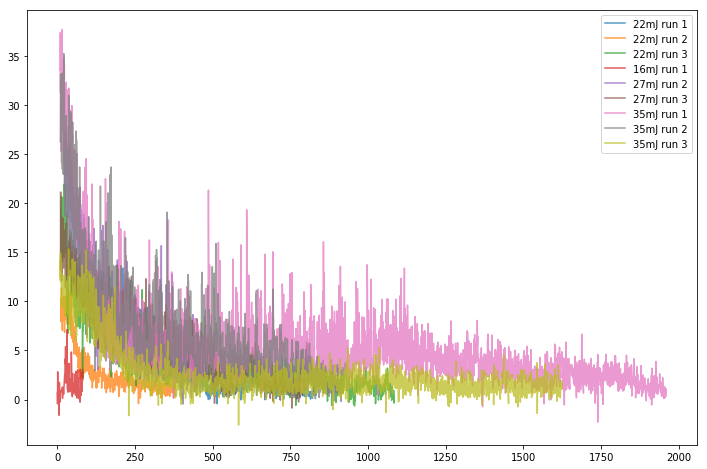

In [40]:
fig, ax = plt.subplots(figsize = (12,8))
for key in integrals_runs:
    tmp = key.split(' ')
    energy = tmp[1]
    run_nr = tmp[-1]
    try:
        run_nr = int(run_nr)
    except Exception as e:
        print(e)
        continue
    data = integrals_runs[key]
    ax.plot(data[:,0]*1/2, data[:,1], label = '{0} run {1}'.format(energy, run_nr),
            alpha = 0.75)
ax.legend()

In [83]:
integrals_runs_averaged = {}
for key in integrals_runs:
    tmp = key.split(' ')
    energy = tmp[1]
    run_nr = tmp[-1]
    try:
        run_nr = int(run_nr)
    except Exception as e:
        print(e)
        continue
    data = integrals_runs[key]
    df = 30
    f_bins = np.arange(data[:,0].min(), data[:,0].max()+df, df)
    bin_indices = np.digitize(data[:,0], f_bins)
    bin_means = np.array([data[:,1][bin_indices == i].mean() for i in range(1, len(f_bins))])
    bin_errors = np.array([data[:,1][bin_indices == i].std() for i in range(1, len(f_bins))])
    midpoint = np.diff(f_bins)/2+f_bins[:-1]
    tmp = []
    for m, v, e in zip(midpoint, bin_means, bin_errors):
        tmp.append((m,v,e))
    integrals_runs_averaged[key] = np.array(tmp)

invalid literal for int() with base 10: 'previous'
invalid literal for int() with base 10: 'crash'


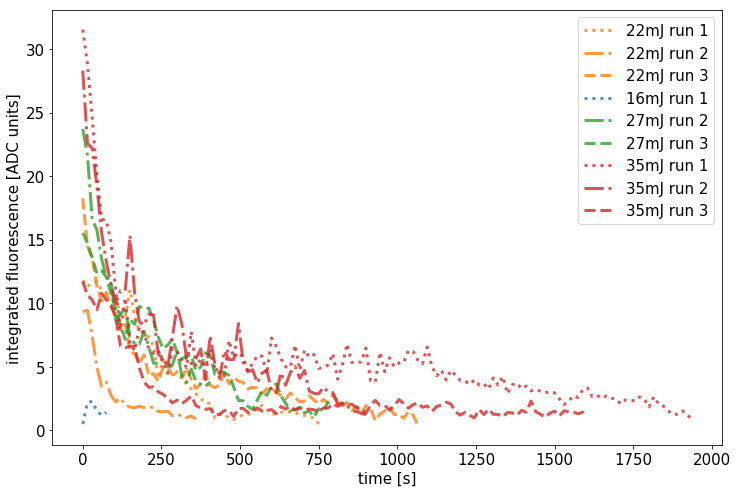

In [105]:
fig, ax = plt.subplots(figsize = (12,8))
for key in integrals_runs_averaged:
    tmp = key.split(' ')
    energy = tmp[1]
    run_nr = tmp[-1]
    try:
        run_nr = int(run_nr)
    except Exception as e:
        print(e)
        continue
    data = integrals_runs_averaged[key]
    if energy == '16mJ':
        c = 'C0'
    elif energy == '22mJ':
        c = 'C1'
    elif energy == '27mJ':
        c = 'C2'
    elif energy == '35mJ':
        c = 'C3'
    if run_nr == 1:
        ls = ':'
    elif run_nr == 2:
        ls = '-.'
    elif run_nr == 3:
        ls = '--'
    ax.plot((data[:,0]-data[0,0])*1/2, data[:,1], label = '{0} run {1}'.format(energy, run_nr),
            alpha = 0.8, lw = 3, linestyle = ls, color = c)
ax.legend(fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('integrated fluorescence [ADC units]', fontsize = 15);

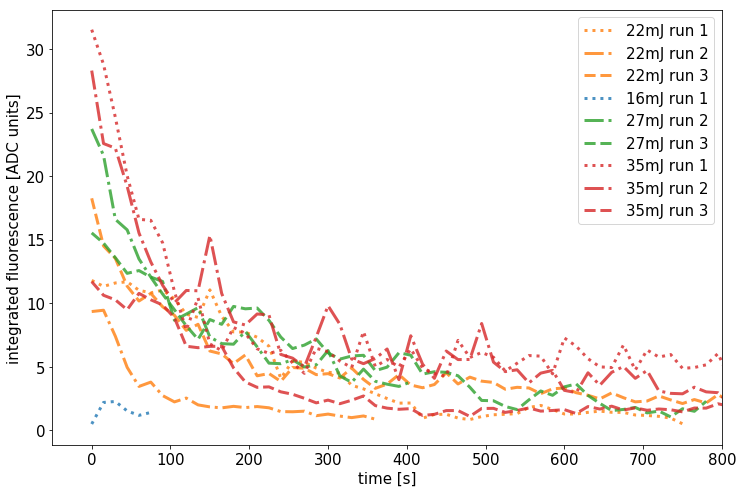

In [106]:
fig, ax = plt.subplots(figsize = (12,8))
for key in integrals_runs_averaged:
    tmp = key.split(' ')
    energy = tmp[1]
    run_nr = tmp[-1]
    try:
        run_nr = int(run_nr)
    except Exception as e:
        print(e)
        continue
    data = integrals_runs_averaged[key]
    if energy == '16mJ':
        c = 'C0'
    elif energy == '22mJ':
        c = 'C1'
    elif energy == '27mJ':
        c = 'C2'
    elif energy == '35mJ':
        c = 'C3'
    if run_nr == 1:
        ls = ':'
    elif run_nr == 2:
        ls = '-.'
    elif run_nr == 3:
        ls = '--'
    ax.plot((data[:,0]-data[0,0])*1/2, data[:,1], label = '{0} run {1}'.format(energy, run_nr),
            alpha = 0.8, lw = 3, linestyle = ls, color = c)
ax.legend(fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('integrated fluorescence [ADC units]', fontsize = 15);
ax.set_xlim((-50,800));

In [107]:
def fit_model(x, a,b,c):
    return a*np.exp(-b*x)+c

22mJ run 1
spot lifetime : 309.74 s
spot lifetime : 618 shots
2429.35
22mJ run 2
spot lifetime : 57.14 s
spot lifetime : 114 shots
614.76
22mJ run 3
spot lifetime : 148.07 s
spot lifetime : 296 shots
2329.81
16mJ run 1
spot lifetime : -205782.96 s
spot lifetime : -411564 shots
3.45
27mJ run 2
spot lifetime : 89.93 s
spot lifetime : 178 shots
1275.51
27mJ run 3
spot lifetime : 360.69 s
spot lifetime : 720 shots
2784.28
35mJ run 1
spot lifetime : 82.24 s
spot lifetime : 164 shots
1316.53
35mJ run 2
spot lifetime : 137.56 s
spot lifetime : 274 shots
1444.74
35mJ run 3
spot lifetime : 145.37 s
spot lifetime : 290 shots
2817.04


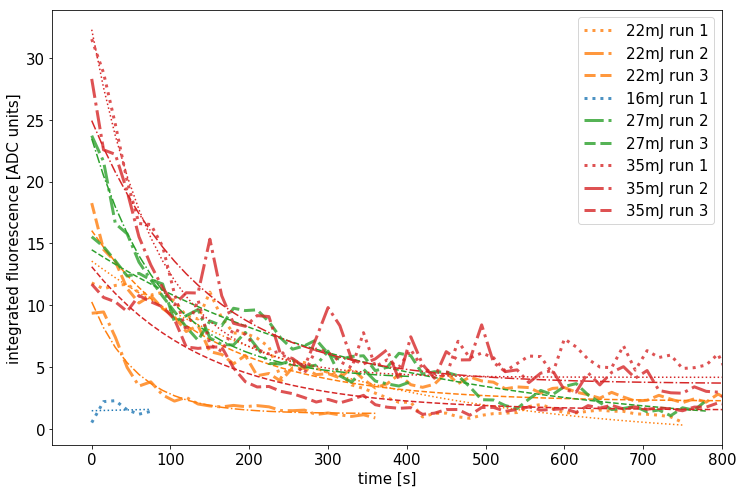

In [118]:
from scipy.optimize import curve_fit

fig, ax = plt.subplots(figsize = (12,8))
for key in integrals_runs_averaged:
    tmp = key.split(' ')
    energy = tmp[1]
    run_nr = tmp[-1]
    try:
        run_nr = int(run_nr)
    except Exception as e:
        print(e)
        continue
    data = integrals_runs_averaged[key]
    if energy == '16mJ':
        c = 'C0'
    elif energy == '22mJ':
        c = 'C1'
    elif energy == '27mJ':
        c = 'C2'
    elif energy == '35mJ':
        c = 'C3'
    if run_nr == 1:
        ls = ':'
    elif run_nr == 2:
        ls = '-.'
    elif run_nr == 3:
        ls = '--'
    ax.plot((data[:,0]-data[0,0])*1/2, data[:,1], label = '{0} run {1}'.format(energy, run_nr),
            alpha = 0.8, lw = 3, linestyle = ls, color = c)
    
    p0 = (20,1,0)
    popt, pcov = curve_fit(fit_model, (data[:,0]-data[0,0])*1/2, data[:,1], p0 = p0)
    ax.plot((data[:,0]-data[0,0])*1/2, fit_model((data[:,0]-data[0,0])*1/2, *popt), color = c, ls = ls)
    print('{0} run {1}'.format(energy, run_nr))
    print('spot lifetime : {0:.2f} s'.format(1/popt[1]))
    print('spot lifetime : {0} shots'.format(2*int(1/popt[1])))
    print('='*30)
ax.legend(fontsize = 15)
ax.tick_params(axis='both', which='major', labelsize=15)
ax.tick_params(axis='both', which='minor', labelsize=15)
ax.set_xlabel('time [s]', fontsize = 15)
ax.set_ylabel('integrated fluorescence [ADC units]', fontsize = 15);
ax.set_xlim((-50,800));
fig.savefig("ablation_decay.png")